## LLM

In [1]:
import sys
sys.path.insert(0, '../src/')

import matplotlib.pyplot as plt
from tokenizer import TokenizerBPE
from data_handling import normalize_to_ascii, clean_text
from utils import saver, loader
import numpy as np
import re

import os
import pickle as pkl
from tqdm.notebook import tqdm
import json

# disable gpu for testing purposes
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


## QuAC

In [3]:
with open('../corpus/train_v0.2.json', 'r', encoding='utf-8') as f:
    quac = json.load(f)

data = quac["data"]
length = len(data)
print("QuAC length: ", length)

QuAC length:  11567


In [4]:
context_list = []

question_grouped = []
answer_grouped = []

for article in quac["data"]:
    for paragraph in article['paragraphs']:
        question_grouped.append([])
        answer_grouped.append([])
        context_list.append(clean_text(normalize_to_ascii(paragraph['context'].replace(" CANNOTANSWER", ""))))
        for qa in paragraph['qas']:
                question = qa['question']
                answer = qa['answers'][0]["text"]

                question_grouped[-1].append(clean_text(normalize_to_ascii(question)))
                answer_grouped[-1].append(clean_text(normalize_to_ascii(answer)))

In [5]:
saver("../corpus/quac_raw", [context_list, question_grouped, answer_grouped])

In [11]:
len_list = [len(x) for x in context_list]

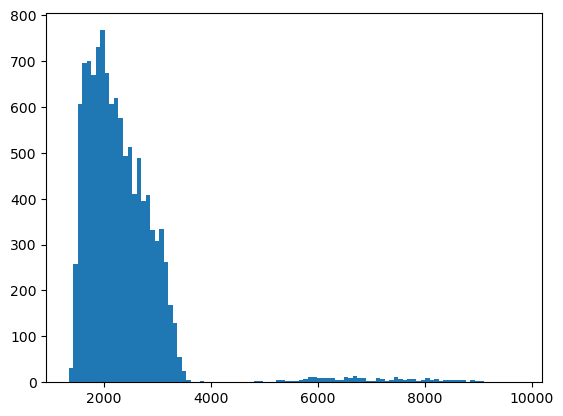

In [12]:
plt.hist(len_list, bins=100)
plt.show()

In [6]:
def fused_sqa(story_list, question_grouped_list, answer_grouped_list):
    q ="<q>"
    a = "<a>"
    sos = "<s>"
    eos = "</s>"

    rcw = re.compile(r"\s+")

    corpus_list = []
    for story, question_list, answer_list in tqdm(list(zip(story_list, question_grouped_list, answer_grouped_list))):
        story = story.replace("\n", " ").replace("\r", " ")
        story = rcw.sub(" ", story).strip()
        sqa = [sos, normalize_to_ascii(story).lower()]
        for question, answer in zip(question_list, answer_list):
            question = question.replace("\n", " ").replace("\r", " ")
            question = rcw.sub(" ", question).strip()
            answer = answer.replace("\n", " ").replace("\r", " ")
            answer = rcw.sub(" ", answer).strip()
            sqa.append(q)
            sqa.append(normalize_to_ascii(question).lower())
            sqa.append(a)
            sqa.append(normalize_to_ascii(answer).lower())
        sqa.append(eos)
        corpus_list.append("".join(sqa))
        
    return corpus_list

In [7]:
fused = fused_sqa(context_list, question_grouped, answer_grouped)

  0%|          | 0/11567 [00:00<?, ?it/s]

## 